## Number classifier task

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sn
import sklearn
import time
import resource
from functools import wraps
from matplotlib.ticker import EngFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable


### Utils functions

In [5]:
def func_timeit(func):
    """Wrapper to print execution time of function"""
    time_formatter = EngFormatter(unit='s', places=2)
    @wraps(func)
    def wrapper(*args, **kwargs):
        # Wall time
        start_wall = time.time()

        # CPU and system time
        usage_start = resource.getrusage(resource.RUSAGE_SELF)
        start_user = usage_start.ru_utime
        start_sys = usage_start.ru_stime

        result = func(*args, **kwargs)

        # Wall time
        end_wall = time.time()

        # CPU and system time
        usage_end = resource.getrusage(resource.RUSAGE_SELF)
        end_user = usage_end.ru_utime
        end_sys = usage_end.ru_stime

        print(f"[{func.__name__}] Wall time: {time_formatter(end_wall - start_wall)}", end=", ")
        print(f"user CPU time: {time_formatter(end_user - start_user)}", end=", ")
        print(f"system time: {time_formatter(end_sys - start_sys)}")
        return result
    return wrapper

def extract_data(path):
    """Load data from .mat file"""
    raw_data = scipy.io.loadmat(path, simplify_cells=True)
    # the data is structured such that it is stored as F-contigous (check by print(trainv.flags))
    # in memort, which drastically reduces performance. Therefore, cast it to C-contigous 
    trainv = np.ascontiguousarray(raw_data["trainv"])
    trainlab = np.ascontiguousarray(raw_data["trainlab"])
    testv = np.ascontiguousarray(raw_data["testv"])
    testlab = np.ascontiguousarray(raw_data["testlab"])
    
    return trainv, trainlab, testv, testlab

def reshape_matrix(mat):
    """Reshape each line in the matrix into a quadratic image"""
    reshapedMat = []
    
    for i in range(np.size(mat,0)):
        reshapedMat.append(mat[i,:].reshape(28,28))

    return np.array(reshapedMat)


def generate_conf_matrix(predicted_labels, true_labels):
    """Generate a confusion matrix"""
    # 0-axis / y-axis: true class
    # 1-axis / x-axis: predicted class
    conf_matrix = np.zeros((10,10), dtype=int)

    for i in range(len(predicted_labels)):

        predicted_class = predicted_labels[i]        
        true_classs = true_labels[i]

        conf_matrix[true_classs][predicted_class] += 1
    
    return conf_matrix


def calculate_performances(conf_matrix):
    """Calculate the precision, recall and accuracy"""
    # Precision: correctly classified as class i / all classified as class i
    precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
    # Recall: correctly classified as class i / all true class i
    recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    # Accuracy: correctly classified / all samples
    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    return precision, recall, accuracy


def generate_conf_matrix_figure(conf_matrix, title):
    """Create a plt.Figure representation of the confusion matrix"""
    confusion_fig = plt.figure(figsize = (10,7))
    confusion_fig = sn.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    
    _, _, accuracy = calculate_performances(conf_matrix)
    confusion_fig.set_title(f"{title}. Accuracy: {accuracy:.2%}")


    confusion_fig.set_ylabel("True class")
    confusion_fig.set_xlabel("Predicted class")

    confusion_fig.set_xticklabels(list(range(0, conf_matrix.shape[0])))
    confusion_fig.set_yticklabels(list(range(0, conf_matrix.shape[0])))
    return confusion_fig

### kNN implementation

In [246]:
@func_timeit
def knn(data_to_be_classified, labeled_data, k):
    """Get the k nearest neighbours of each datapoint to be classified"""
    n_samples = data_to_be_classified.shape[0]
    block_size = 500
    
    knn_idx = np.zeros((n_samples, k), dtype=int)

    for i in range(0, n_samples, block_size):

        distance = scipy.spatial.distance.cdist(data_to_be_classified[i:i+block_size], labeled_data, metric="euclidean")
        part = np.argpartition(distance, kth=k, axis=1)  # Sort element k correct, with all elements to the left of it smaller
        knn_idx[i:i+block_size] = part[:, :k]

    return knn_idx

In [6]:
# Load data
trainv, trainlab, testv, testlab = extract_data("numbers_data/data_all.mat")

### Classify all samples using NN

In [248]:
# Calculate results of only NN (KNN, K=1)
knn_idx = knn(data_to_be_classified=testv, labeled_data=trainv, k=1)
nn_idx = knn_idx[:, 0]  # Only one element is returned
nn_pred = trainlab[nn_idx]

[knn] Wall time: 170.41 s, user CPU time: 168.55 s, system time: 1.86 s


### Display confusion matrix and error rates for NN classification

Accuracy: 96.91%
0 precision: 97.99%, recall: 99.29%
1 precision: 96.74%, recall: 99.47%
2 precision: 98.41%, recall: 96.12%
3 precision: 96.13%, recall: 96.04%
4 precision: 97.22%, recall: 96.13%
5 precision: 95.13%, recall: 96.41%
6 precision: 98.13%, recall: 98.54%
7 precision: 95.66%, recall: 96.50%
8 precision: 98.08%, recall: 94.46%
9 precision: 95.65%, recall: 95.84%


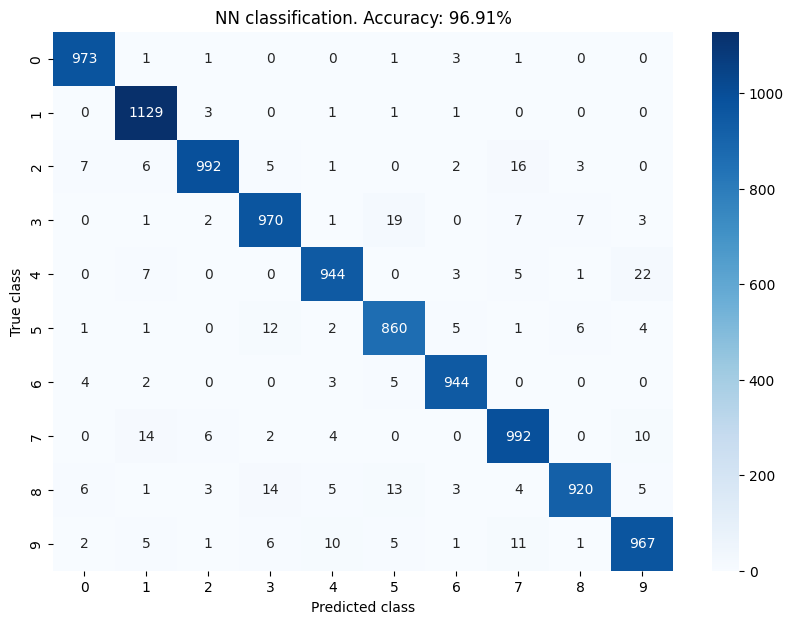

In [249]:
conf_matrix = generate_conf_matrix(nn_pred, testlab)
generate_conf_matrix_figure(conf_matrix, "NN classification")
precision, recall, accuracy = calculate_performances(conf_matrix)
print(f"Accuracy: {accuracy:.2%}")
for i, cls in enumerate(list(range(10))):
    print(f"{cls} precision: {precision[i]:.2%}, recall: {recall[i]:.2%}")

### Some correctly classified and missclassified images

Samples where true class is 9 and NN predicted 4: [1192 1232 1901 3160 3850 4314 4665 4823 5639 9808]


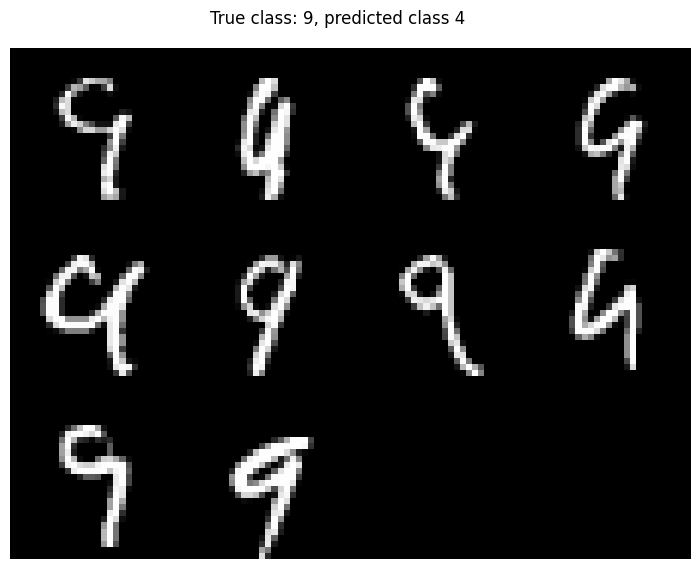

In [250]:
true_class = 9
predicted_class = 4

idxs = np.where((nn_pred == predicted_class) & (testlab == true_class))[0]
print(f"Samples where true class is {true_class} and NN predicted {predicted_class}: {idxs}")

cols = int(np.ceil(np.sqrt(len(idxs))))
rows = int(np.ceil(len(idxs)/cols))


fig = plt.figure(figsize=(2*cols, 2*rows))
fig.suptitle(f"True class: {true_class}, predicted class {predicted_class}")
sup_image = np.zeros((rows*28, cols*28))
for r in range(rows):
    for c in range(cols):
        if (r*cols+c) >= len(idxs):
            continue

        idx = idxs[r*cols+c]
        sup_image[r*28:(r+1)*28, c*28:(c+1)*28] = testv[idx].reshape((28, 28))

plt.imshow(sup_image, cmap="grey")
plt.tight_layout()
plt.axis("off");

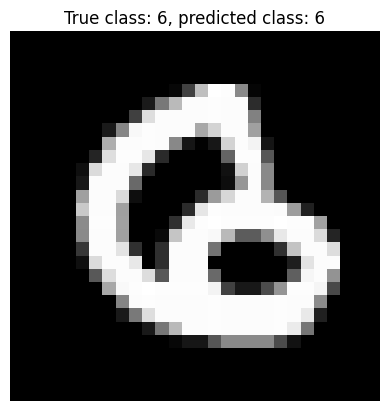

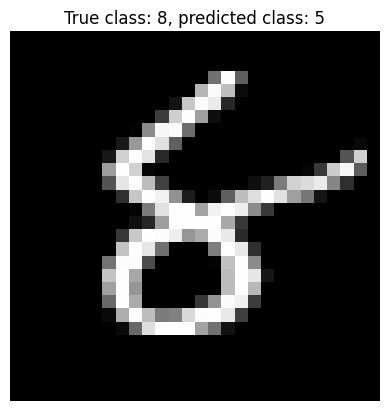

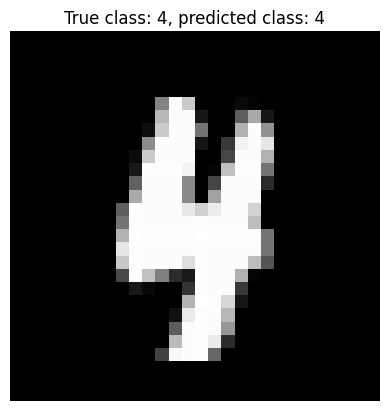

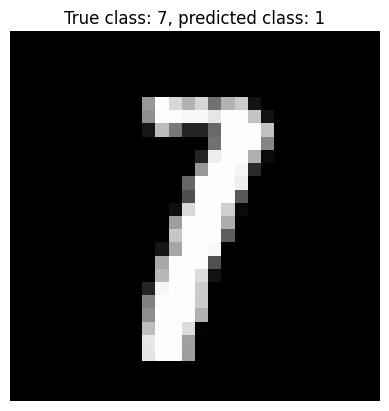

In [251]:
np.random.seed(20)
num_samples = 2
correctly_classified_idxs = np.where(nn_pred == testlab)[0]
incorrectly_classified_idxs = np.where(nn_pred != testlab)[0]

for i in range(num_samples):
    random_correct_idx = np.random.choice(correctly_classified_idxs)
    random_incorrect_idx = np.random.choice(incorrectly_classified_idxs)
    
    plt.figure()
    plt.imshow(testv[random_correct_idx].reshape((28, 28)), cmap='gray')
    plt.title(f"True class: {testlab[random_correct_idx]}, predicted class: {nn_pred[random_correct_idx]}")
    plt.axis("off")
    
    plt.figure()
    plt.imshow(testv[random_incorrect_idx].reshape((28, 28)), cmap='gray')
    plt.title(f"True class: {testlab[random_incorrect_idx]}, predicted class: {nn_pred[random_incorrect_idx]}")
    plt.axis("off")

### K-means clustering

In [7]:
def centroids_init_random(k):
    """Initialize centroids to random points in space"""
    return np.random.uniform(0, 255, (k, 784))


def centroids_init_gaussian(k):
    """Initialize centroids to random points with a gaussian mask"""
    P = 28
    x, y = np.mgrid[0:P, 0:P]
    pos = np.dstack((x, y))
    std = P/5
    rv = scipy.stats.multivariate_normal(mean=[P//2]*2, cov=np.diag([std**2, std**2]))

    gauss = rv.pdf(pos)
    # Normalize peak to be one, lose the pdf normalization property
    gauss = (gauss - gauss.min()) / (gauss.max() - gauss.min())
    return np.random.uniform(0, 255, (k, 784)) * gauss.flatten()


def centroids_init_random_datapoints(data, k):
    """Initialize centroids to random datapoints"""
    random_indicies = np.random.choice(data.shape[0], k, replace=False)
    return data[random_indicies]

def centroids_init_kpp(data, k):
    """Initialize centroids using the k-means++ algorithm. This means selecting each
    cluster sequentially from the data, with the probability of a data point being
    chosen as a cluster increasing with distance to closest cluster."""

    # Allocate space for clusters
    centroids = np.zeros((k, 784))

    # Choose first centroid at random
    np.random.randint(0, len(data)-1)
    centroids[0] = data[0]
    # Remove this cluster from the data so that it is not chosen again
    data = np.delete(data, 0, axis=0)

    # We need to initalize this array to be able to stack it later on
    data_dist_to_centroids = scipy.spatial.distance.cdist(data, [centroids[0]], metric='euclidean')

    # Repeat the procedure until we have k clusters
    for i in range(1, k):
        # Compute distance from each datapoint to each cluster
        # Removing computation of distance to all centroids every cycle
        # improved efficiency dramatically
        data_dist_to_centroids = np.column_stack((
            data_dist_to_centroids,
            scipy.spatial.distance.cdist(data, [centroids[i-1]], metric='euclidean')
        ))

        # Find closest centroid for each datapoint
        closest_centroid_dist = np.min(data_dist_to_centroids, axis=1)
        # Square for proper distance measure
        closest_centroid_dist_prob = np.square(closest_centroid_dist)
        # Normalize to get pmf (probability mass function)
        closest_centroid_dist_prob /= np.sum(closest_centroid_dist_prob)
        # Pick a data point as the new cluster at random using the weighter pmf
        new_centroid_idx = np.random.choice(data.shape[0], p=closest_centroid_dist_prob)
        centroids[i] = data[new_centroid_idx]
        
        # We should delete the datapoint to avoid choosing it again
        data = np.delete(data, new_centroid_idx, axis=0)
        data_dist_to_centroids = np.delete(data_dist_to_centroids, new_centroid_idx, axis=0)
        
    return centroids

def initialize_centroids(data, k, init_type):
    """Initialize the centroids according to the type chosen"""
    if init_type == "random":
        centroids = centroids_init_random(k)
    elif init_type == "random-datapoints":
        centroids = centroids_init_random_datapoints(data, k)
    elif init_type == "gaussian":
        centroids = centroids_init_gaussian(k)
    elif init_type == "k-means++":
        centroids = centroids_init_kpp(data, k)
    else:
        raise ValueError
    return centroids

@func_timeit
def k_means(data, k, max_iterations, init_type="gaussian"):
    """Perform k-means clustering on the data. Return the new centroids
    and the change in the norm of each centroid for each iteration"""
    centroids = initialize_centroids(data, k, init_type)
    centroids_diff_iterations = np.zeros((max_iterations, k))
    iteration = 0

    while iteration < max_iterations:
        
        # For each sample in data, calculate the distance to each centroid
        distance_to_centroids = scipy.spatial.distance.cdist(data, centroids, metric='euclidean')
        # Assign each sample to the closest centroid
        cluster_idxs = np.argmin(distance_to_centroids, axis=1)
        
        # Iterate over each cluster
        for i in range(k):
            # Get all the datapoints belonging to this cluster
            cluster_data = data[cluster_idxs == i]
            # If any points belong to the cluster, update its center be the mean
            # of the points belonging to it
            if len(cluster_data):
                mean = np.mean(cluster_data, axis=0)
                centroids_diff_iterations[iteration][i] = np.linalg.norm(centroids[i] - mean)
                centroids[i] = mean
        iteration += 1
    
    return centroids, centroids_diff_iterations

def show_data_as_image(data, size, title, ylab, xlab, cmap, axis="off"):
    """Display a 2D-array as an image with a colorbar and no axis"""
    fig = plt.figure(figsize=size)
    ax = plt.gca()
    ax.set_title(title)
    ax.set_ylabel(xlab)
    ax.set_xlabel(ylab)
    im = ax.imshow(data, cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    fig.colorbar(im, cax=cax)
    ax.axis(axis)

def display_convergence(centroids_diff_iterations, n, M=64):
    """Display an image showing how the centroids for number n with M clusters
    changed over each iteration"""
    fig = plt.figure(figsize=(15,8))
    ax = plt.gca()
    ax.set_title(f"Change in 2-norm of each centroid for class {n}")
    ax.set_ylabel("Iteration")
    ax.set_xlabel("Centroid")

    im = ax.imshow(centroids_diff_iterations[:, n*M:(n+1)*M], cmap="RdBu")
        
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    fig.colorbar(im, cax=cax)

def display_centroids(centroids, n, M=64):
    """Show the M first centroids for the number n"""
    p = int(np.ceil(np.sqrt(M)))
    fig = plt.figure(figsize=(p, p))
    fig.suptitle(f"Centroids for class: {n}")
    sup_image = np.zeros((p*28, p*28))
    for r in range(p):
        for c in range(p):
            idx = r*p+c

            sup_image[r*28:(r+1)*28, c*28:(c+1)*28] = centroids[n*M+idx].reshape((28, 28))

    plt.imshow(sup_image, cmap="grey")
    plt.tight_layout()
    plt.axis("off")


### Perform k-means clustering with 64 clusters for each digit

In [253]:
# Split labeled data by class
trainv_by_class = []
for i in range(10):
    trainv_by_class.append(trainv[trainlab == i])

# Create M clusters for each class, run for clustering algorithm for N iterations
M = 64
N = 15

[k_means] Wall time: 1.45 s, user CPU time: 1.37 s, system time: 75.01 ms
[k_means] Wall time: 1.53 s, user CPU time: 1.46 s, system time: 77.00 ms
[k_means] Wall time: 1.37 s, user CPU time: 1.30 s, system time: 71.03 ms
[k_means] Wall time: 1.41 s, user CPU time: 1.33 s, system time: 75.02 ms
[k_means] Wall time: 1.34 s, user CPU time: 1.26 s, system time: 72.94 ms
[k_means] Wall time: 1.25 s, user CPU time: 1.18 s, system time: 62.04 ms
[k_means] Wall time: 1.37 s, user CPU time: 1.29 s, system time: 77.94 ms
[k_means] Wall time: 1.45 s, user CPU time: 1.37 s, system time: 76.01 ms
[k_means] Wall time: 1.34 s, user CPU time: 1.26 s, system time: 74.95 ms
[k_means] Wall time: 1.36 s, user CPU time: 1.29 s, system time: 75.98 ms


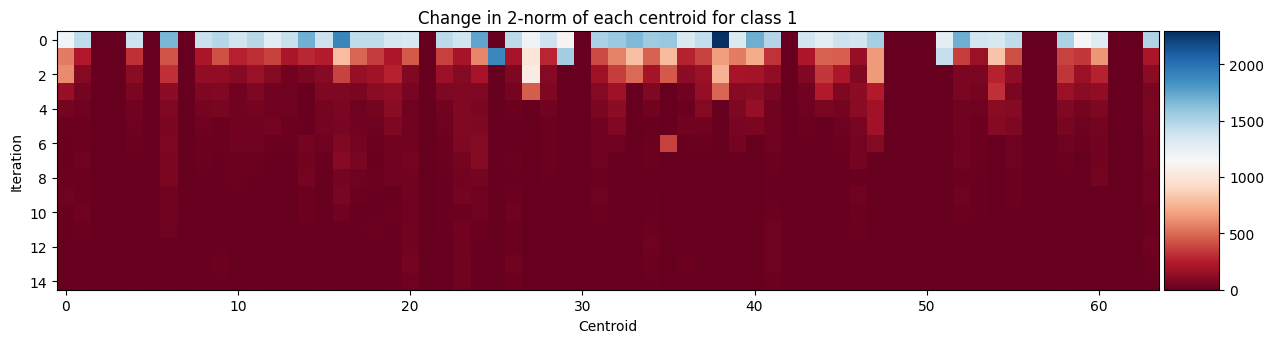

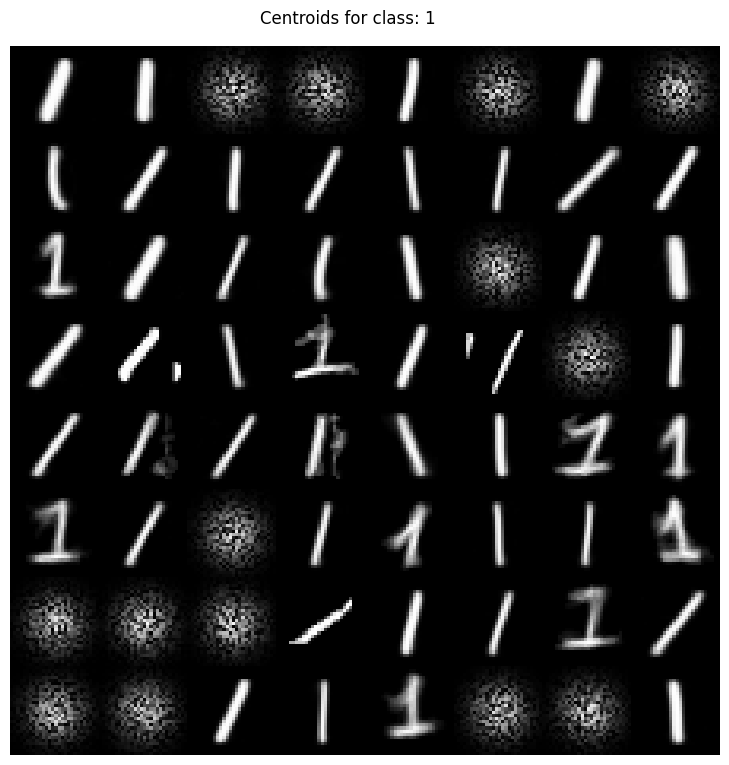

In [254]:
# Store the centroids sequentially
centroids = np.zeros((M*10, 784))
diff = np.zeros((N, M*10))

# Create labels for centroids
centroids_lab = np.zeros(M*10, dtype=int)
for i in range(10):
    centroids_lab[i*M:(i+1)*M] = [i]*M

# Perform clustering on each class

for i in range(10):
    centroids_class, diff_class = k_means(
                                    data=trainv_by_class[i],
                                    k=M,
                                    max_iterations=N
                                )
    centroids[i*M:(i+1)*M] = centroids_class
    diff[:, i*M:(i+1)*M] = diff_class

n=1
display_convergence(diff, n, M)
display_centroids(centroids, n, M)
    

### Perform NN on clustered data

[knn] Wall time: 1.47 s, user CPU time: 1.46 s, system time: 45.00 µs
Accuracy: 95.27%
0 precision: 96.39%, recall: 98.06%
1 precision: 97.08%, recall: 99.74%
2 precision: 96.74%, recall: 94.77%
3 precision: 95.00%, recall: 94.06%
4 precision: 95.44%, recall: 93.79%
5 precision: 94.08%, recall: 94.39%
6 precision: 97.50%, recall: 97.70%
7 precision: 95.62%, recall: 93.48%
8 precision: 94.52%, recall: 93.94%
9 precision: 90.13%, recall: 92.27%


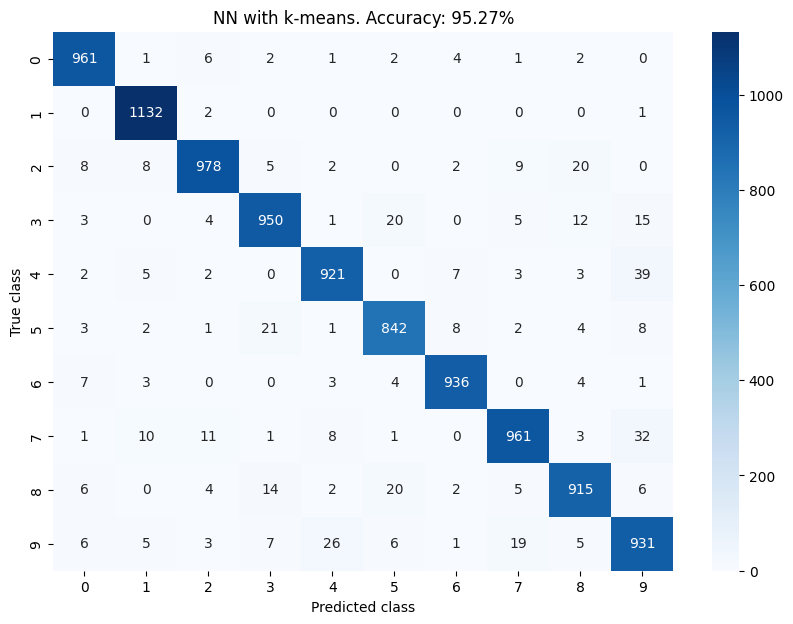

In [255]:
# k=1 implies we only find 1 neighbour
knn_idx = knn(data_to_be_classified=testv, labeled_data=centroids, k=1)
nn_idx = knn_idx[:, 0]

nn_pred = centroids_lab[nn_idx]

conf_matrix = generate_conf_matrix(nn_pred, testlab)
generate_conf_matrix_figure(conf_matrix, "NN with k-means")
precision, recall, accuracy = calculate_performances(conf_matrix)
print(f"Accuracy: {accuracy:.2%}")
for i, cls in enumerate(list(range(10))):
    print(f"{cls} precision: {precision[i]:.2%}, recall: {recall[i]:.2%}")


### Perform KNN (K=7) on clustered data

[knn] Wall time: 1.46 s, user CPU time: 1.46 s, system time: 1.91 ms
Accuracy: 93.71%
0 precision: 95.54%, recall: 98.27%
1 precision: 93.06%, recall: 99.21%
2 precision: 95.92%, recall: 91.18%
3 precision: 92.37%, recall: 93.47%
4 precision: 93.05%, recall: 92.67%
5 precision: 92.66%, recall: 93.39%
6 precision: 96.26%, recall: 96.66%
7 precision: 94.47%, recall: 91.44%
8 precision: 93.43%, recall: 90.45%
9 precision: 90.52%, recall: 89.89%


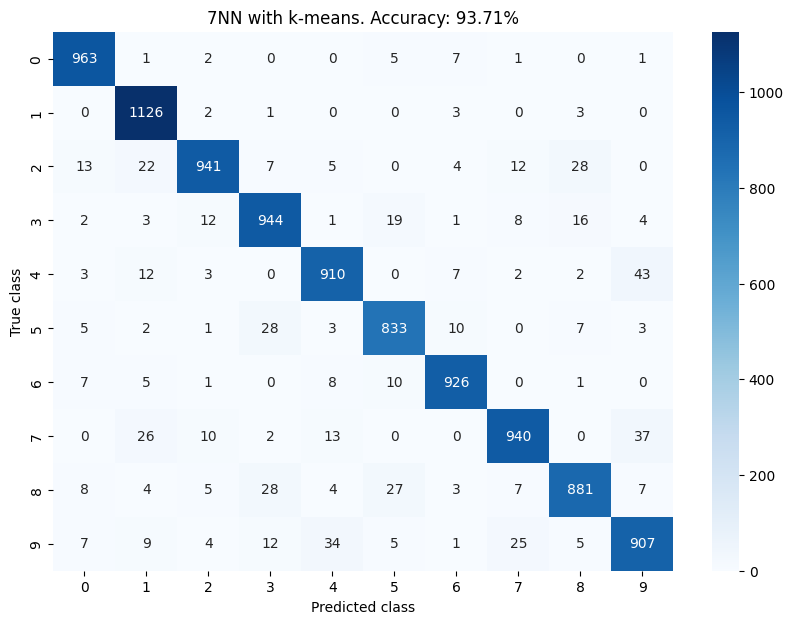

In [256]:
K = 7

knn_idx = knn(data_to_be_classified=testv, labeled_data=centroids, k=K)
knn_idx = knn_idx.flatten(order="C")                        # Store the data sequentially to be able to get labels efficiently
knn_labels = centroids_lab[knn_idx]                         # Get label of all neighbours
knn_labels = knn_labels.reshape((int(1e4), K), order="C")   # Cast back into the original shape to take
knn_pred = scipy.stats.mode(knn_labels, axis=1).mode        # Get the most common neighbour

conf_matrix = generate_conf_matrix(knn_pred, testlab)
generate_conf_matrix_figure(conf_matrix, "7NN with k-means")
precision, recall, accuracy = calculate_performances(conf_matrix)
print(f"Accuracy: {accuracy:.2%}")
for i, cls in enumerate(list(range(10))):
    print(f"{cls} precision: {precision[i]:.2%}, recall: {recall[i]:.2%}")
    

### Remarks regarding initialization of centroids

The naive approach for choosing the initial centroid locations is to choose random vectors. As we will see, this can leave many of the clusters totally untouched by the kmeans algorithm because no datapoints are nearby. We will compare the naive approach to two standard methods:
* choosing existing datapoints at random as initial centroids
* choosing existing datapoints using the kmeans++ algortihm as initial centroids

In addition, one can exploit that the numbers exhibit some similarity, and therefore one approach cold be to apply a mask to a random noise image to create the initial centroids. We won't dive deep into how one could choose a suiting mask. By inspecting the data one can see that the images are brighter in the middle and darker at the edges. One possible choice of a mask could be a 2D gaussian (a symmetric one is a reasonable choice). By applying this mask to a random noise image one can get more suitable initial centroids. The concept is illustrated below

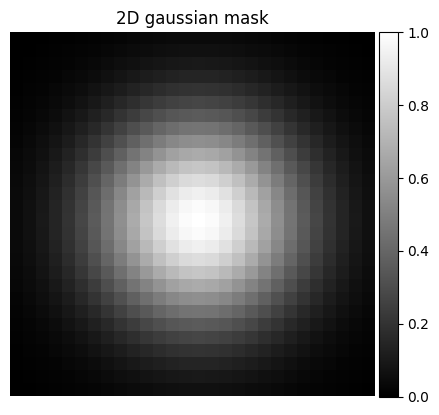

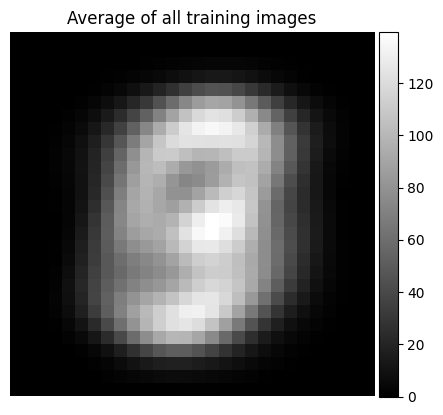

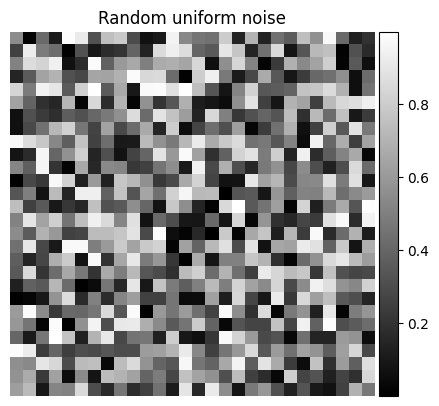

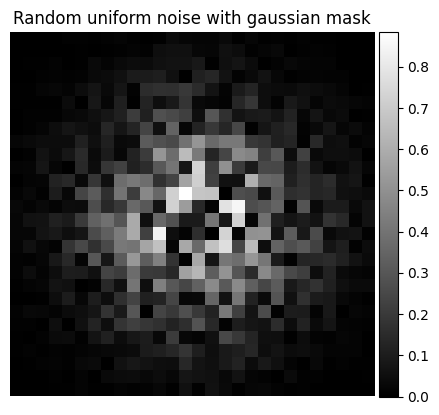

In [8]:
# 2D gaussian
P = 28
x, y = np.mgrid[0:P, 0:P]
pos = np.dstack((x, y))
# Create a 2D Gaussian with center in the middel of the image
# that vanished at the edges.
std = P/5
rv = scipy.stats.multivariate_normal(mean=[P//2]*2, cov=np.diag([std**2, std**2]), seed=42)
gauss = rv.pdf(pos)
# Normalize peak to be one, lose the pdf normalization property
gauss = (gauss - gauss.min()) / (gauss.max() - gauss.min())

show_data_as_image(gauss, (5,5), "2D gaussian mask", "", "", cmap="gray")

# Display the average of the training data as well
show_data_as_image(np.mean(trainv, axis=0).reshape(28,28), (5,5), "Average of all training images", "", "", cmap="gray")


random_imgs = np.random.uniform(0, 1, size=(10, P*P))
show_data_as_image(random_imgs[0].reshape((P,P)), (5,5), "Random uniform noise", "", "", cmap="gray")

# Apply gaussina mask to emphasize center
images_weighted = random_imgs * gauss.flatten()
show_data_as_image(images_weighted[0].reshape((P,P)), (5,5), "Random uniform noise with gaussian mask", "", "", cmap="gray")


In [258]:
def test_convergence_sequence(M, n=1, init_type="gaussian", use_sklearn=""):
    """Script to test the different types of initialization.
    Asess the performance if the clusters by using NN on the resulting them"""
    
    np.random.seed(42)
    # Store the centroids sequentially
    centroids = np.zeros((M*10, 784))
    diff = np.zeros((N, M*10))

    # Create labels for centroids
    centroids_lab = np.zeros(M*10, dtype=int)
    for i in range(10):
        centroids_lab[i*M:(i+1)*M] = [i]*M

    average_cycles = []
    # Perform clustering on each class
    for i in range(10):
        if not use_sklearn:
            centroids_class, diff_class = k_means(
                                            data=trainv_by_class[i],
                                            init_type=init_type,
                                            k=M,
                                            max_iterations=N
                                        )
            diff[:, i*M:(i+1)*M] = diff_class
            average_cycles.append(N)

        elif use_sklearn:
            kmeans = sklearn.cluster.KMeans(n_clusters=M, random_state=42, init=init_type)
            kmeans.fit_predict(trainv_by_class[i])          # Cluster data
            centroids_class = kmeans.cluster_centers_       # Get centroids
            average_cycles.append(kmeans.n_iter_)


        centroids[i*M:(i+1)*M] = centroids_class

    if not sklearn:
        display_convergence(diff, n, M)

    display_centroids(centroids, n, M)

    knn_idx = knn(data_to_be_classified=testv, labeled_data=centroids, k=1)
    nn_idx = knn_idx[:, 0]

    nn_pred = centroids_lab[nn_idx]

    conf_matrix = generate_conf_matrix(nn_pred, testlab)
    precision, recall, accuracy = calculate_performances(conf_matrix)
    print(f"Average number of iterations for kmeans clustering of each class: {np.mean(average_cycles):.1f}")
    print(f"NN accuracy using k-means clusters: {accuracy:.2%}")


### Random centroids

[k_means] Wall time: 1.42 s, user CPU time: 1.34 s, system time: 76.99 ms
[k_means] Wall time: 1.61 s, user CPU time: 1.53 s, system time: 83.01 ms
[k_means] Wall time: 1.42 s, user CPU time: 1.34 s, system time: 81.45 ms
[k_means] Wall time: 1.40 s, user CPU time: 1.32 s, system time: 70.99 ms
[k_means] Wall time: 1.35 s, user CPU time: 1.28 s, system time: 64.99 ms
[k_means] Wall time: 1.23 s, user CPU time: 1.16 s, system time: 66.96 ms
[k_means] Wall time: 1.35 s, user CPU time: 1.28 s, system time: 71.99 ms
[k_means] Wall time: 1.42 s, user CPU time: 1.35 s, system time: 67.95 ms
[k_means] Wall time: 1.36 s, user CPU time: 1.28 s, system time: 73.98 ms
[k_means] Wall time: 1.35 s, user CPU time: 1.28 s, system time: 73.95 ms
[knn] Wall time: 1.49 s, user CPU time: 1.57 s, system time: 159.99 ms
Average number of iterations for kmeans clustering of each class: 15.0
NN accuracy using k-means clusters: 94.21%
Total time usage
CPU times: user 14.8 s, sys: 923 ms, total: 15.7 s
Wall ti

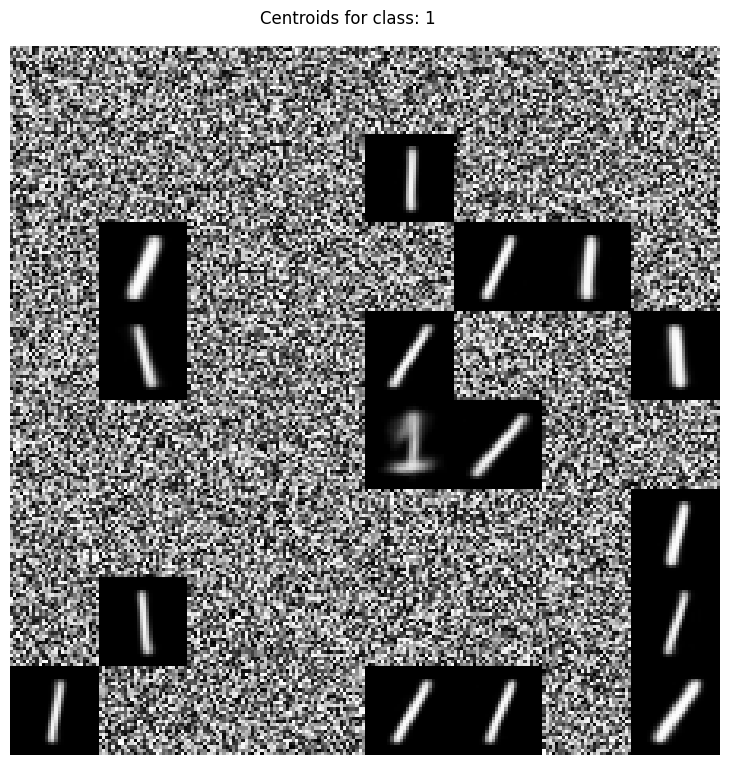

In [259]:
%%time
test_convergence_sequence(M=64, init_type="random")
print("Total time usage")

### Random centroids with gaussian mask

[k_means] Wall time: 1.38 s, user CPU time: 1.31 s, system time: 72.02 ms
[k_means] Wall time: 1.55 s, user CPU time: 1.47 s, system time: 78.94 ms
[k_means] Wall time: 1.37 s, user CPU time: 1.30 s, system time: 78.96 ms
[k_means] Wall time: 1.41 s, user CPU time: 1.34 s, system time: 67.98 ms
[k_means] Wall time: 1.35 s, user CPU time: 1.29 s, system time: 65.01 ms
[k_means] Wall time: 1.25 s, user CPU time: 1.18 s, system time: 64.97 ms
[k_means] Wall time: 1.37 s, user CPU time: 1.29 s, system time: 76.02 ms
[k_means] Wall time: 1.44 s, user CPU time: 1.35 s, system time: 84.96 ms
[k_means] Wall time: 1.36 s, user CPU time: 1.29 s, system time: 68.96 ms
[k_means] Wall time: 1.37 s, user CPU time: 1.30 s, system time: 64.99 ms
[knn] Wall time: 1.43 s, user CPU time: 1.50 s, system time: 177.95 ms
Average number of iterations for kmeans clustering of each class: 15.0
NN accuracy using k-means clusters: 95.26%
Total time usage
CPU times: user 14.7 s, sys: 921 ms, total: 15.6 s
Wall ti

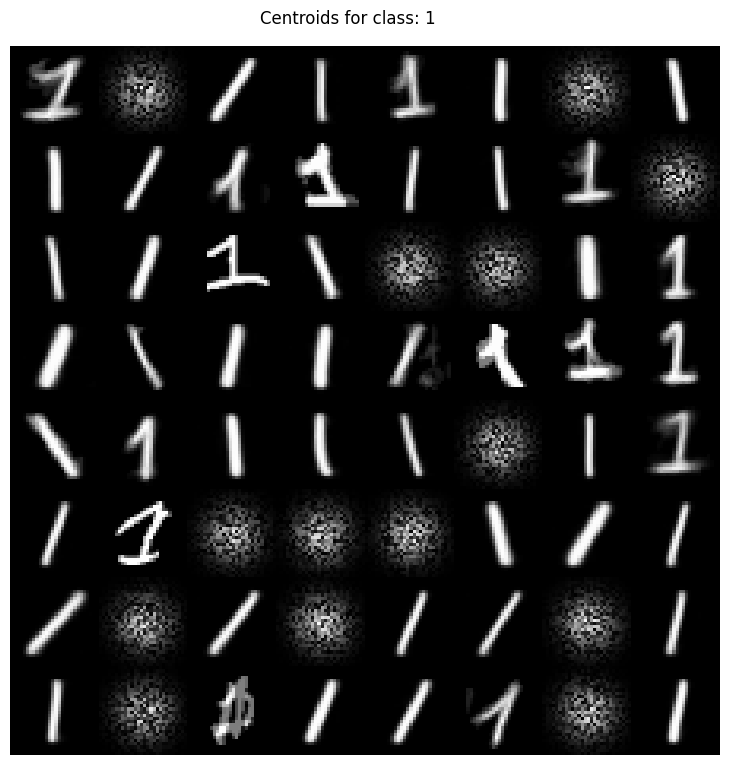

In [260]:
%%time
test_convergence_sequence(M=64, init_type="gaussian")
print("Total time usage")

### Centroids chosen using k-means++

[k_means] Wall time: 2.04 s, user CPU time: 1.63 s, system time: 402.82 ms
[k_means] Wall time: 2.30 s, user CPU time: 1.89 s, system time: 404.94 ms
[k_means] Wall time: 2.02 s, user CPU time: 1.65 s, system time: 377.84 ms
[k_means] Wall time: 2.05 s, user CPU time: 1.69 s, system time: 358.95 ms
[k_means] Wall time: 2.01 s, user CPU time: 1.65 s, system time: 358.84 ms
[k_means] Wall time: 1.89 s, user CPU time: 1.55 s, system time: 337.89 ms
[k_means] Wall time: 2.07 s, user CPU time: 1.70 s, system time: 371.89 ms
[k_means] Wall time: 2.12 s, user CPU time: 1.74 s, system time: 378.91 ms
[k_means] Wall time: 2.03 s, user CPU time: 1.68 s, system time: 349.92 ms
[k_means] Wall time: 2.02 s, user CPU time: 1.65 s, system time: 366.91 ms
[knn] Wall time: 1.42 s, user CPU time: 1.46 s, system time: 196.99 ms
Average number of iterations for kmeans clustering of each class: 15.0
NN accuracy using k-means clusters: 95.28%
Total time usage
CPU times: user 18.3 s, sys: 3.93 s, total: 22.3

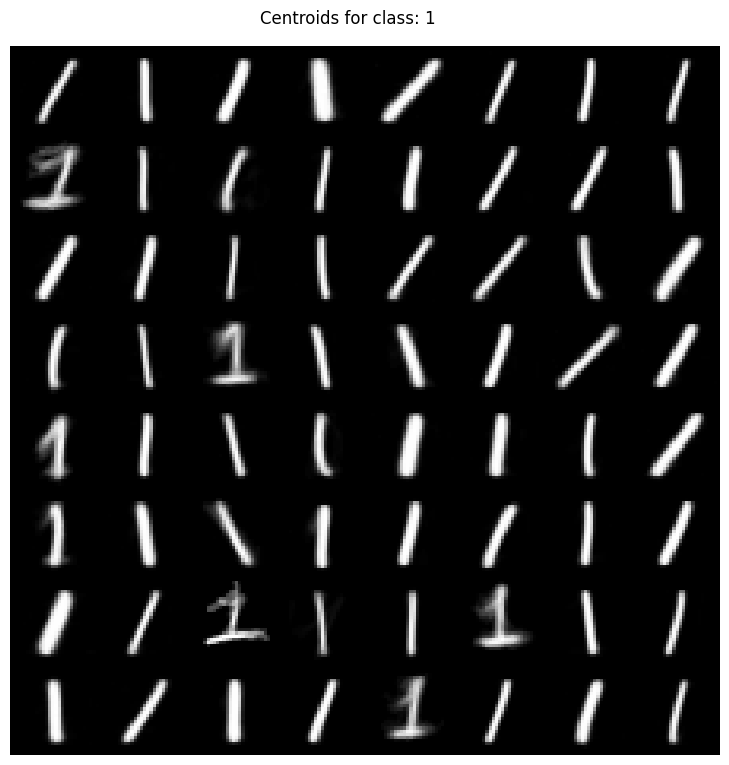

In [261]:
%%time
test_convergence_sequence(M=64, init_type="k-means++")
print("Total time usage")

### Centroids chosen at random from datapoints

[k_means] Wall time: 1.37 s, user CPU time: 1.30 s, system time: 75.96 ms
[k_means] Wall time: 1.55 s, user CPU time: 1.47 s, system time: 77.97 ms
[k_means] Wall time: 1.37 s, user CPU time: 1.30 s, system time: 73.00 ms
[k_means] Wall time: 1.41 s, user CPU time: 1.33 s, system time: 76.46 ms
[k_means] Wall time: 1.34 s, user CPU time: 1.27 s, system time: 68.99 ms
[k_means] Wall time: 1.25 s, user CPU time: 1.19 s, system time: 60.97 ms
[k_means] Wall time: 1.37 s, user CPU time: 1.30 s, system time: 73.97 ms
[k_means] Wall time: 1.44 s, user CPU time: 1.36 s, system time: 75.00 ms
[k_means] Wall time: 1.34 s, user CPU time: 1.27 s, system time: 72.04 ms
[k_means] Wall time: 1.37 s, user CPU time: 1.29 s, system time: 77.98 ms
[knn] Wall time: 1.41 s, user CPU time: 1.48 s, system time: 178.07 ms
Average number of iterations for kmeans clustering of each class: 15.0
NN accuracy using k-means clusters: 95.28%
Total time usage
CPU times: user 14.6 s, sys: 940 ms, total: 15.6 s
Wall ti

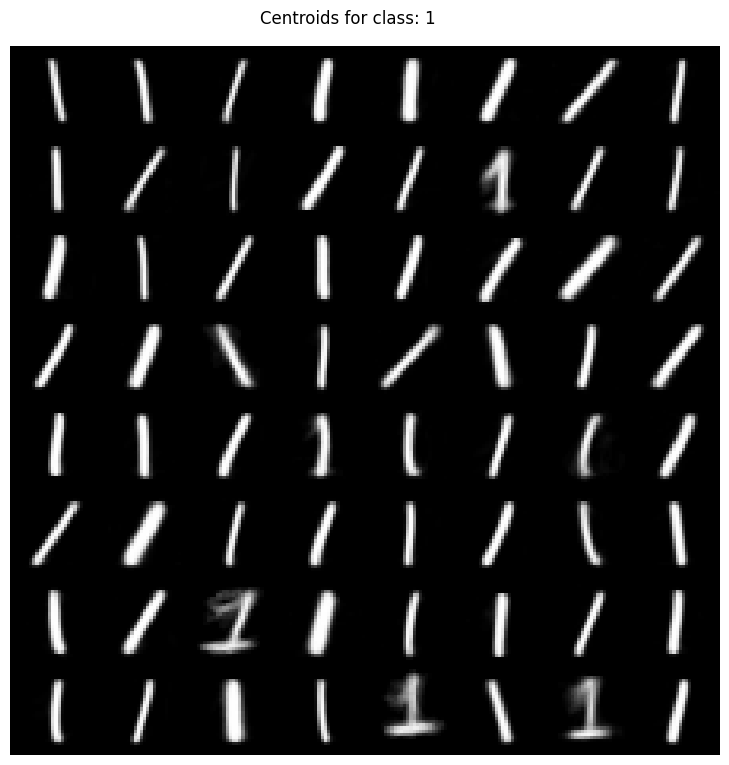

In [262]:
%%time
test_convergence_sequence(M=64, init_type="random-datapoints")
print("Total time usage")

### Sklearn learn k-means++

[knn] Wall time: 1.85 s, user CPU time: 1.90 s, system time: 183.82 ms
Average number of iterations for kmeans clustering of each class: 41.3
NN accuracy using k-means clusters: 95.23%
Total time usage
CPU times: user 1min 26s, sys: 22 s, total: 1min 48s
Wall time: 10.1 s


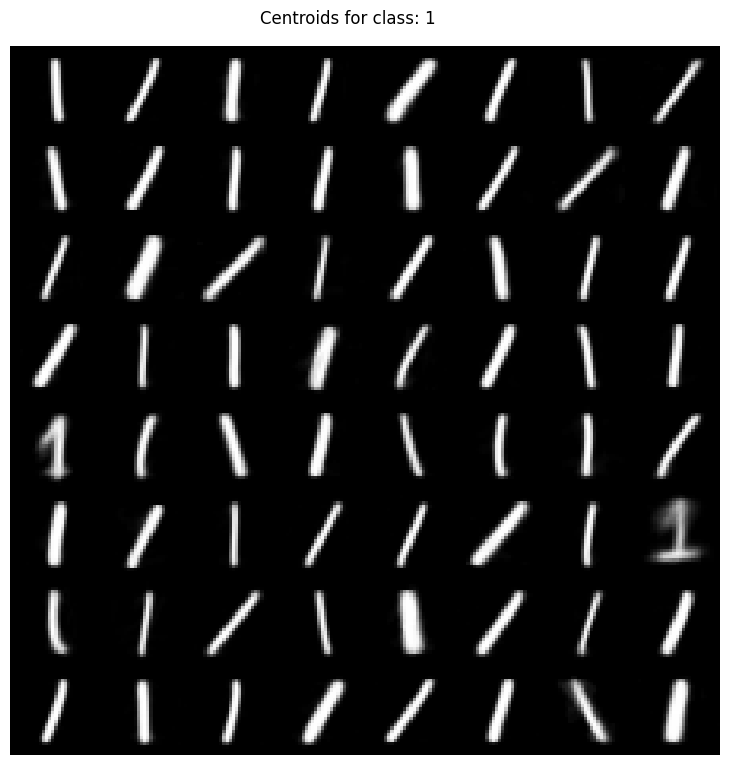

In [263]:
%%time
test_convergence_sequence(M=64, init_type="k-means++", use_sklearn=True)
print("Total time usage")

### Sklearn pick random datapoints

[knn] Wall time: 1.63 s, user CPU time: 1.69 s, system time: 186.02 ms
Average number of iterations for kmeans clustering of each class: 46.8
NN accuracy using k-means clusters: 95.30%
Total time usage
CPU times: user 8min 8s, sys: 1.34 s, total: 8min 9s
Wall time: 42.8 s


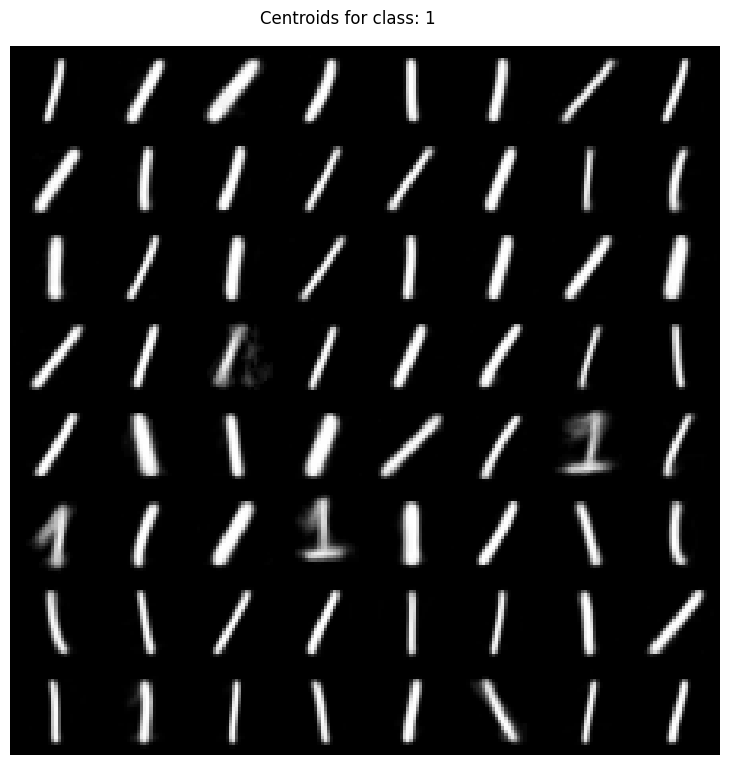

In [264]:
%%time
test_convergence_sequence(M=64, init_type="random", use_sklearn=True)
print("Total time usage")